In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import csv
import pandas
import sklearn
import numpy as np

Reading data

In [2]:
messages = pandas.read_csv('./data/SMSSpamCollection.txt', sep='\t', quoting=csv.QUOTE_NONE,
                           names=["label", "message"])

<h4>Examining Data we have</h4>

In [3]:
print messages.head()

  label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...


In [4]:
print "Shape = " , messages.shape, "\n"
print "Class Distribution = \n", messages.label.value_counts()

Shape =  (5574, 2) 

Class Distribution = 
ham     4827
spam     747
Name: label, dtype: int64


<h4>Preprocessing starts<h4>

In [5]:
#adding a column of length
messages['length'] = messages['message'].map(lambda text: len(text))

Defining functions to split the sentence
 1. Split into tokens
 2. Split into lemmas which changes words into lemmas after splitting into tokens

In [53]:
from textblob import TextBlob

In [7]:
# 1. 
def split_into_tokens(message):
    message = unicode(message, 'utf8')  # convert bytes into proper unicode
    return TextBlob(message).words

In [8]:
# 2.
def split_into_lemmas(message):
    message = unicode(message, 'utf8').lower()
    words = TextBlob(message).words
    # for each word, take its "base form" = lemma 
    return [word.lemma for word in words]

In [9]:
X = messages.message
y = messages.label
print type(X), X.shape
print type(y), y.shape

<class 'pandas.core.series.Series'> (5574L,)
<class 'pandas.core.series.Series'> (5574L,)


In [10]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print X_train.shape
print y_train.shape

(4459L,)
(4459L,)


Vectorising our sentences by making a vocabulary of words using
1. split into lemmas as analyser
2. stop words = english (inbuilt)

In [11]:
#import
from sklearn.feature_extraction.text import CountVectorizer
#instantiate
bow_vectorizer = CountVectorizer(analyzer=split_into_lemmas, stop_words='english')
print bow_vectorizer
#fit
bow_vectorizer.fit(X_train)
#transform
messages_bow = bow_vectorizer.transform(X_train)

CountVectorizer(analyzer=<function split_into_lemmas at 0x000000000A0C1DD8>,
        binary=False, decode_error=u'strict', dtype=<type 'numpy.int64'>,
        encoding=u'utf-8', input=u'content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preprocessor=None,
        stop_words='english', strip_accents=None,
        token_pattern=u'(?u)\\b\\w\\w+\\b', tokenizer=None,
        vocabulary=None)


SAVING VOCAB

In [32]:
bow_transformer=CountVectorizer(analyzer=split_into_lemmas, stop_words='english').fit(messages['message'])

In [ ]:
vocab=bow_transformer.vocabulary_
print type(vocab)
import json
with open('Failed.txt', 'w') as outfile:   
    json.dump(vocab, outfile)
#import json2html
#data=json.loads('Failed.txt')
#print json2html.convert(json = vocab)
    
#import cPickle as pickle
#with open('data.p', 'wb') as fp:          //.p FORMAT
    #pickle.dump(vocab, fp)

In [12]:
print type(messages_bow)
print 'sparse matrix shape:', messages_bow.shape
print 'number of non-zeros:', messages_bow.nnz
print 'sparsity: %.2f%%' % (100.0 * messages_bow.nnz / (messages_bow.shape[0] * messages_bow.shape[1]))

<class 'scipy.sparse.csr.csr_matrix'>
sparse matrix shape: (4459, 7798)
number of non-zeros: 64000
sparsity: 0.18%


Using stop words has decremented our vocabulary by a 1000 words
from 8874 to 7793

<br>
Now using <b>TF-IDF</b> to transform our bag of words matrix

In [13]:
#import
from sklearn.feature_extraction.text import TfidfTransformer
#instantiate
tfidf_transformer = TfidfTransformer()
#fit and transform
messages_tfidf_X_train = tfidf_transformer.fit_transform(messages_bow)

In [27]:
from scipy import sparse, io
io.mmwrite("test.mtx", messages_tfidf_X_train)

<h4> Training our model </h4>

<h6>1. Logistic Regression</h6>

In [24]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
%time params_logreg = logreg.fit(messages_tfidf_X_train, y_train)
print type(params_logreg)
print logreg.coef_.size

Wall time: 28 ms
<class 'sklearn.linear_model.logistic.LogisticRegression'>
7855


<h6>2. Naive Bayes<h6>

In [46]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
%time params_nb = nb.fit(messages_tfidf_X_train, y_train)
print type(params_nb)
print nb.coef_.size

Wall time: 18 ms
<class 'sklearn.naive_bayes.MultinomialNB'>
7798


# <h6>3. K neighbors<h6>

In [16]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=2,algorithm="brute")
neigh.fit(messages_tfidf_X_train,y_train)

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=2, p=2,
           weights='uniform')



<h4>Testing the models<h4>

In [19]:
#converting X_test to suitable form for input
X_test_tfidf = tfidf_transformer.transform(bow_vectorizer.transform(X_test))

In [25]:
y_pred_logreg = logreg.predict(X_test_tfidf)

In [17]:
y_pred_nb = nb.predict(X_test_tfidf)

NameError: name 'nb' is not defined

In [20]:
y_pred_km=neigh.predict(X_test_tfidf)

In [22]:
from sklearn.metrics import classification_report, f1_score, confusion_matrix,metrics

D:\Anaconda2.7Python\lib\site-packages\sklearn\metrics\metrics.py:4: DeprecationWarning: sklearn.metrics.metrics is deprecated and will be removed in 0.18. Please import from sklearn.metrics
  DeprecationWarning)


TODO: Using second method (manual one) to transform testing set

In [26]:
#Logistic Regression Accuracy
print metrics.accuracy_score(y_test, y_pred_logreg)

0.977578475336


In [37]:
print 'confusion matrix\n', confusion_matrix(y_test, y_pred_logreg)
print '(row=expected, col=predicted)'

confusion matrix
[[967   0]
 [ 29 119]]
(row=expected, col=predicted)


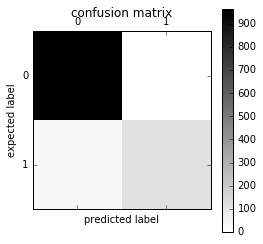

In [38]:
plt.matshow(confusion_matrix(y_test, y_pred_logreg), cmap=plt.cm.binary, interpolation='nearest')
plt.title('confusion matrix')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')

In [73]:
print classification_report(y_test, y_pred_logreg)

             precision    recall  f1-score   support

        ham       0.86      1.00      0.92       954
       spam       0.00      0.00      0.00       161

avg / total       0.73      0.86      0.79      1115



/home/priyal27/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [20]:
#Naive Bayes Accuracy
print metrics.accuracy_score(y_test, y_pred_nb)

0.949775784753


In [44]:
print 'confusion matrix\n', confusion_matrix(y_test, y_pred_nb)
print '(row=expected, col=predicted)'

confusion matrix
[[967   0]
 [ 51  97]]
(row=expected, col=predicted)


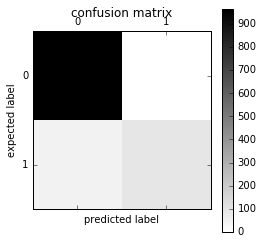

In [45]:
plt.matshow(confusion_matrix(y_test, y_pred_nb), cmap=plt.cm.binary, interpolation='nearest')
plt.title('confusion matrix')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')

In [46]:
print classification_report(y_test, y_pred_nb)

             precision    recall  f1-score   support

        ham       0.95      1.00      0.97       967
       spam       1.00      0.66      0.79       148

avg / total       0.96      0.95      0.95      1115



In [23]:
#K neighbors Accuracy
print metrics.accuracy_score(y_test, y_pred_km)

0.935426008969


In [40]:
print 'confusion matrix\n', confusion_matrix(y_test, y_pred_nb)
print '(row=expected, col=predicted)'

confusion matrix
[[883  79]
 [130  23]]
(row=expected, col=predicted)


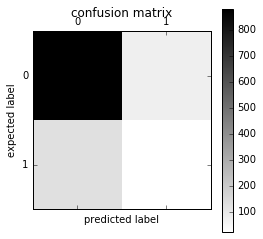

In [41]:
plt.matshow(confusion_matrix(y_test, y_pred_nb), cmap=plt.cm.binary, interpolation='nearest')
plt.title('confusion matrix')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')

In [36]:
print classification_report(y_test, y_pred_nb)

             precision    recall  f1-score   support

        ham       0.85      0.91      0.88       944
       spam       0.21      0.13      0.16       171

avg / total       0.75      0.79      0.77      1115



<h6>Using Pipeline and GridSearchCV<h6>

In [54]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=split_into_lemmas)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [55]:
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedKFold
params = {
    'tfidf__use_idf': (True, False),
    'bow__analyzer': (split_into_lemmas, split_into_tokens),
}

grid = GridSearchCV(
    pipeline,  # pipeline from above
    params,  # parameters to tune via cross validation
    refit=True,  # fit using all available data at the end, on the best found param combination
    n_jobs=-1,  # number of cores to use for parallelization; -1 for "all cores"
    scoring='accuracy',  # what score are we optimizing?
    cv=StratifiedKFold(y_train, n_folds=5),  # what type of cross validation to use
)

In [ ]:
nb_detector = grid.fit(X_train, y_train)

In [ ]:
print nb_detector.grid_scores_

In [ ]:
y_pred_nb_grid = nb_detector.predict(X_test)

In [ ]:
print metrics.accuracy_score(y_test, y_pred_nb_grid)

In [ ]:
print 'confusion matrix\n', confusion_matrix(y_test, y_pred_nb_grid)
print '(row=expected, col=predicted)'

In [ ]:
print classification_report(y_test, y_pred_nb_grid)


Results improved!